# About this Report

## Report Objective

Study Quadratic Assignment Problem (QAP), formulating problem, solving it
using these 3 solvers and study the result:

- Gurobi Optimizer (Runs on CPU)  
- Fixstars Amplify (Simulate annealing on GPU)  
- D-Wave Advantage (Quantum Annealing on QPU)

# Quadratic Assignment Problem (QAP)

Quadratic Assignment Problem (QAP) is a combinatorial optimization problem that seeks to assign $n$ facilities to $n$ locations in such a way as to minimize the assignment cost. The assignment cost is the sum of the product of the interaction between facilities and the distance between locations.

## Example Problem

Let's say we have 4 facilities: Office, Factory, Warehouse, and Store. We want to assign these facilities to 4 locations: Location A, Location B, Location C, and Location D. The interaction between the facilities and the distance between the locations are given in the following tables:

| Interaction | Office | Factory | Warehouse | Store |
| ----------- | ------ | ------- | --------- | ----- |
| Office      | -      | 5       | 2         | 4     |
| Factory     | 5      | -       | 3         | 1     |
| Warehouse   | 2      | 3       | -         | 6     |
| Store       | 4      | 1       | 6         | -     |

The location distance is given by the following table:

| Distance   | Location A | Location B | Location C | Location D |
| ---------- | ---------- | ---------- | ---------- | ---------- |
| Location A | -          | 2          | 3          | 4          |
| Location B | 2          | -          | 5          | 6          |
| Location C | 3          | 5          | -          | 7          |
| Location D | 4          | 6          | 7          | -          |

We want to assign facilities that interact frequently (for example, Store and Warehouse)
to be close to each other in order to minimize the cost.


## Solving with Brute Force

This can be done by trying all possible assignments.

### Variable Declaration

In [3]:
facility_name = ["Office", "Factory", "Warehouse", "Store"]
location_name = ["Location A", "Location B", "Location C", "Location D"]

interaction_matrix = [
    [0, 5, 2, 4],
    [5, 0, 3, 1],
    [2, 3, 0, 6],
    [4, 1, 6, 0]
]

distance_matrix = [
    [0, 2, 3, 4],
    [2, 0, 5, 6],
    [3, 5, 0, 7],
    [4, 6, 7, 0]
]

In [4]:
from QAP.graph import draw_graph, assign_facilities

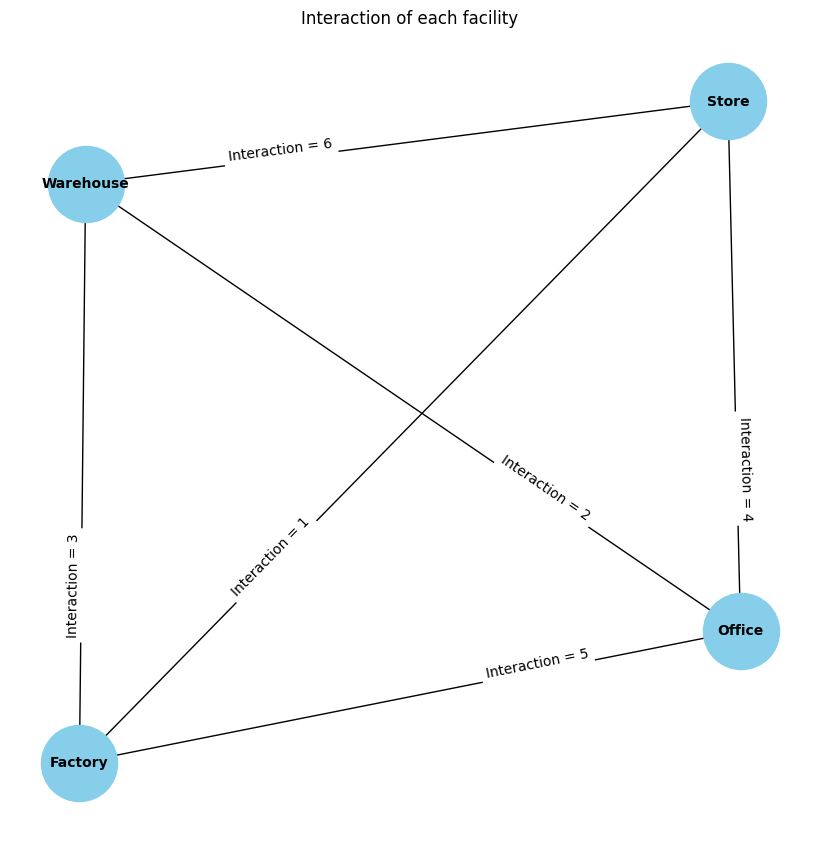

In [5]:
draw_graph("Interaction of each facility", facility_name, [interaction_matrix], ["Interaction"])

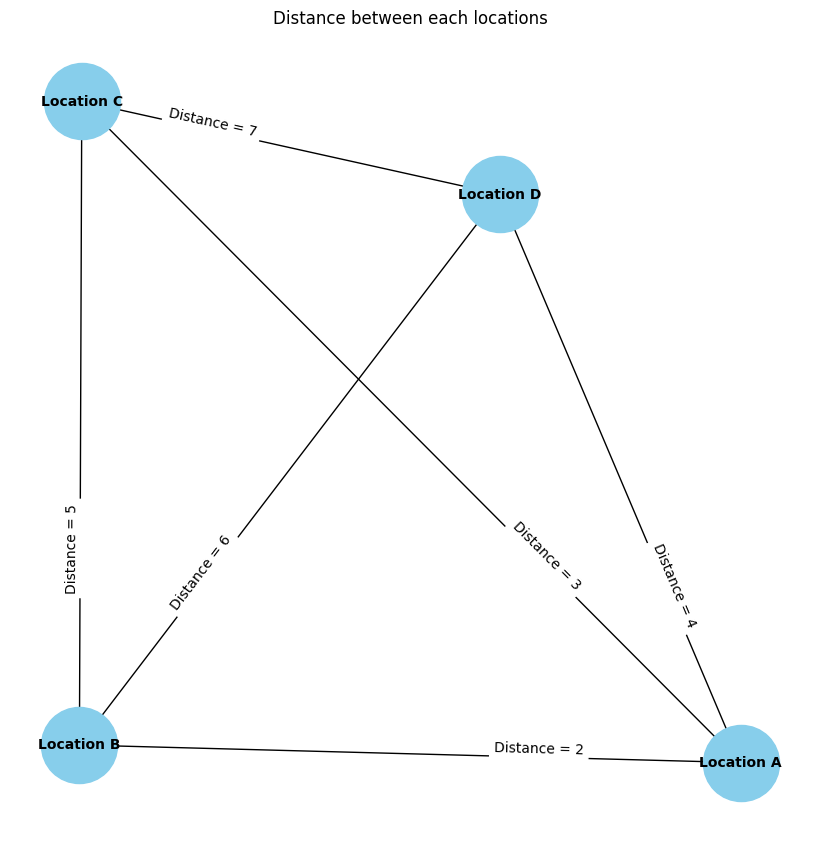

In [6]:
draw_graph("Distance between each locations", location_name, [distance_matrix], ["Distance"])

### Random Solution

Assign randomly yields the following result:

Office is assigned to Location A
Factory is assigned to Location B
Warehouse is assigned to Location C
Store is assigned to Location D
Total Cost: 95


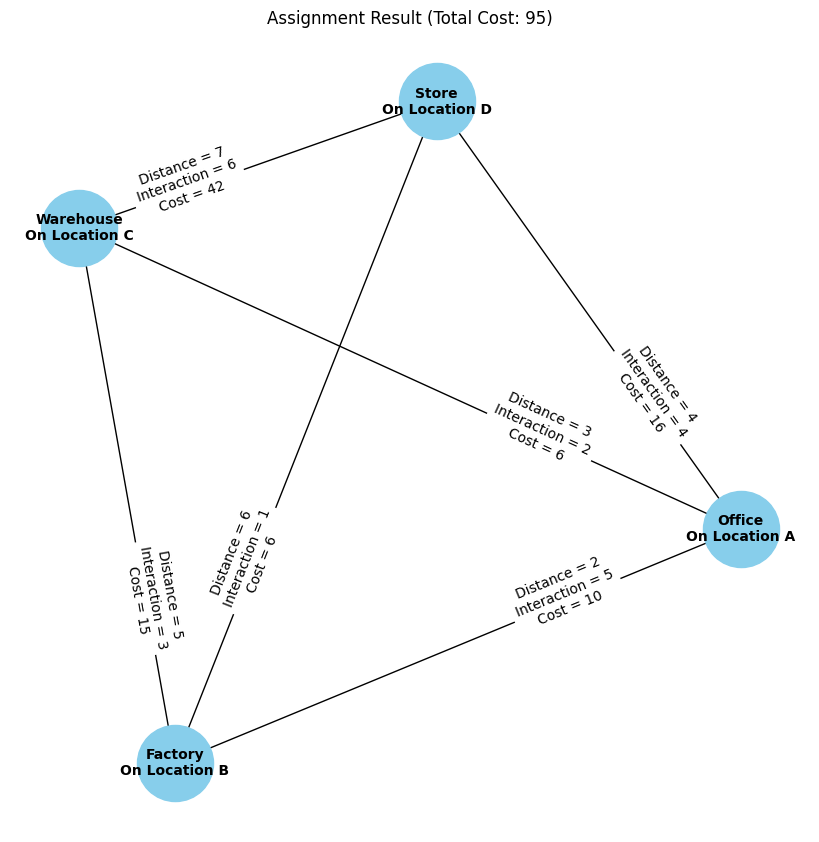

In [7]:
assign_facilities([0, 1, 2, 3], location_name, facility_name, distance_matrix, interaction_matrix)

### Doing Brute Force

Best Cost: 91
Best Permutation: (0, 3, 1, 2)
Office is assigned to Location A
Factory is assigned to Location D
Warehouse is assigned to Location B
Store is assigned to Location C
Total Cost: 91


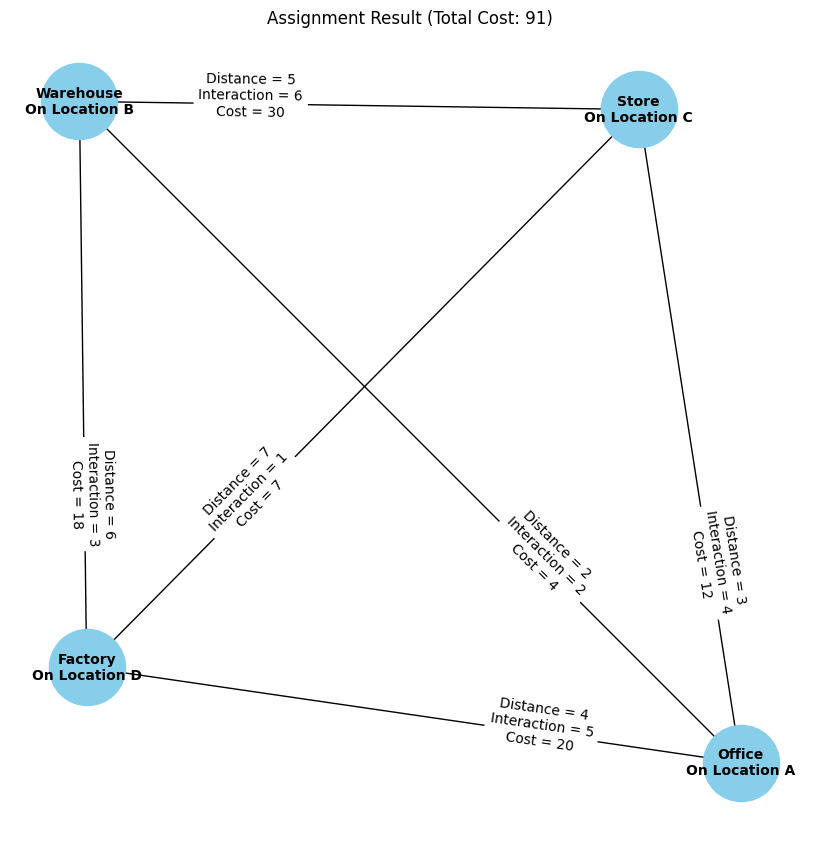

In [8]:
from itertools import permutations

def calculate_cost(interaction_matrix, distance_matrix, assignment):
    cost = 0
    for i in range(len(assignment)):
        for j in range(i + 1, len(assignment)):
            cost += interaction_matrix[i][j] * distance_matrix[assignment[i]][assignment[j]]
    return cost


def solve_bf(interaction_matrix, distance_matrix):
    n = len(interaction_matrix)
    m = len(distance_matrix)
    assert n == m

    best_cost = float('inf')
    best_permutation = ()

    for perm in permutations(range(n)):
        cost = calculate_cost(interaction_matrix, distance_matrix, perm)
        if cost < best_cost:
            best_cost = cost
            best_permutation = perm

    return best_cost, best_permutation

best_cost, best_permutation = solve_bf(interaction_matrix, distance_matrix)

print(f"Best Cost: {best_cost}")
print(f"Best Permutation: {best_permutation}")
assign_facilities(best_permutation, location_name, facility_name, distance_matrix, interaction_matrix)

### Brute Force Summary

Time Complexity: $\mathcal{O}(n! \cdot n^2)$

QAP is an example for NP-hard problem, to solve it for large $n$, we need to use
solvers to help us find the optimal solution in a reasonable time.

# Experiment with Solvers

## Amplify SDK

Amplify SDK is made by Fixstars to solve Quadratic Programming on three solvers mentioned above, this library allow us to formulate the problem once and use it to solve with different solvers.

### Quadratic Programming

A Quadratic Program has two parts, objective and constraints.

The objective is degree 2 polynomial function which we want to minimize and
the constraints are linear equations that the solution must satisfy.

### Formulating Problem to Amplify SDK's model

In [9]:
from amplify import VariableGenerator, one_hot, Poly, ConstraintList
from Utils.latex import obj_to_latex, con_to_latex
from IPython.display import display, Markdown

def create_qap_qp_model(distance_matrix: list[list[int]], interaction_matrix: list[list[int]], weight=1):
    assert (len(distance_matrix) == len(interaction_matrix))
    size = len(distance_matrix)

    gen = VariableGenerator()
    # Facility i on Site j
    q = gen.array(type="Binary", shape=(size, size), name="q")

    obj = Poly()

    for i1 in range(size):
        for j1 in range(size):
            for i2 in range(i1 + 1, size):
                for j2 in range(size):
                    if j1 != j2:
                        obj += q[i1, j1] * q[i2, j2] * \
                            interaction_matrix[i1][i2] * \
                            distance_matrix[j1][j2]

    c = ConstraintList()

    for i in range(size):
        c += one_hot(q[i])
        c += one_hot(q[:, i].sum())

    c *= weight

    model = obj + c

    return {"model": model, "obj": obj, "c": c, "q": q}

model = create_qap_qp_model(distance_matrix, interaction_matrix, 100)

display(Markdown("Objective: Minimize"))
display(Markdown(obj_to_latex(model["obj"])))


display(Markdown("Constraint:"))
display(Markdown(con_to_latex(model["c"])))

Objective: Minimize

Terms Count = 72, Unique Variable = 16  
$10 \cdot q_{0,0} \cdot q_{1,1} + 15 \cdot q_{0,0} \cdot q_{1,2} + 20 \cdot q_{0,0} \cdot q_{1,3} + 4 \cdot q_{0,0} \cdot q_{2,1} + 6 \cdot q_{0,0} \cdot q_{2,2} + 8 \cdot q_{0,0} \cdot q_{2,3} + 8 \cdot q_{0,0} \cdot q_{3,1} + 12 \cdot q_{0,0} \cdot q_{3,2} + 16 \cdot q_{0,0} \cdot q_{3,3} + 10 \cdot q_{0,1} \cdot q_{1,0} + 25 \cdot q_{0,1} \cdot q_{1,2} + 30 \cdot q_{0,1} \cdot q_{1,3} + 4 \cdot q_{0,1} \cdot q_{2,0} + 10 \cdot q_{0,1} \cdot q_{2,2} + 12 \cdot q_{0,1} \cdot q_{2,3} + 8 \cdot q_{0,1} \cdot q_{3,0} + 20 \cdot q_{0,1} \cdot q_{3,2} + 24 \cdot q_{0,1} \cdot q_{3,3} + 15 \cdot q_{0,2} \cdot q_{1,0} + 25 \cdot q_{0,2} \cdot q_{1,1} + 35 \cdot q_{0,2} \cdot q_{1,3} + 6 \cdot q_{0,2} \cdot q_{2,0} + 10 \cdot q_{0,2} \cdot q_{2,1} + 14 \cdot q_{0,2} \cdot q_{2,3} + 12 \cdot q_{0,2} \cdot q_{3,0} + 20 \cdot q_{0,2} \cdot q_{3,1} + 28 \cdot q_{0,2} \cdot q_{3,3} + 20 \cdot q_{0,3} \cdot q_{1,0} + 30 \cdot q_{0,3} \cdot q_{1,1} + 35 \cdot q_{0,3} \cdot q_{1,2} + 8 \cdot q_{0,3} \cdot q_{2,0} + 12 \cdot q_{0,3} \cdot q_{2,1} + 14 \cdot q_{0,3} \cdot q_{2,2} + 16 \cdot q_{0,3} \cdot q_{3,0} + 24 \cdot q_{0,3} \cdot q_{3,1} + 28 \cdot q_{0,3} \cdot q_{3,2} + 6 \cdot q_{1,0} \cdot q_{2,1} + 9 \cdot q_{1,0} \cdot q_{2,2} + 12 \cdot q_{1,0} \cdot q_{2,3} + 2 \cdot q_{1,0} \cdot q_{3,1} + 3 \cdot q_{1,0} \cdot q_{3,2} + 4 \cdot q_{1,0} \cdot q_{3,3} + 6 \cdot q_{1,1} \cdot q_{2,0} + 15 \cdot q_{1,1} \cdot q_{2,2} + 18 \cdot q_{1,1} \cdot q_{2,3} + 2 \cdot q_{1,1} \cdot q_{3,0} + 5 \cdot q_{1,1} \cdot q_{3,2} + 6 \cdot q_{1,1} \cdot q_{3,3} + 9 \cdot q_{1,2} \cdot q_{2,0} + 15 \cdot q_{1,2} \cdot q_{2,1} + 21 \cdot q_{1,2} \cdot q_{2,3} + 3 \cdot q_{1,2} \cdot q_{3,0} + 5 \cdot q_{1,2} \cdot q_{3,1} + 7 \cdot q_{1,2} \cdot q_{3,3} + 12 \cdot q_{1,3} \cdot q_{2,0} + 18 \cdot q_{1,3} \cdot q_{2,1} + 21 \cdot q_{1,3} \cdot q_{2,2} + 4 \cdot q_{1,3} \cdot q_{3,0} + 6 \cdot q_{1,3} \cdot q_{3,1} + 7 \cdot q_{1,3} \cdot q_{3,2} + 12 \cdot q_{2,0} \cdot q_{3,1} + 18 \cdot q_{2,0} \cdot q_{3,2} + 24 \cdot q_{2,0} \cdot q_{3,3} + 12 \cdot q_{2,1} \cdot q_{3,0} + 30 \cdot q_{2,1} \cdot q_{3,2} + 36 \cdot q_{2,1} \cdot q_{3,3} + 18 \cdot q_{2,2} \cdot q_{3,0} + 30 \cdot q_{2,2} \cdot q_{3,1} + 42 \cdot q_{2,2} \cdot q_{3,3} + 24 \cdot q_{2,3} \cdot q_{3,0} + 36 \cdot q_{2,3} \cdot q_{3,1} + 42 \cdot q_{2,3} \cdot q_{3,2}$

Constraint:

Constraint Count: 8  
$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$ (weight: 100)  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$ (weight: 100)  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$ (weight: 100)  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$ (weight: 100)  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$ (weight: 100)  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$ (weight: 100)  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$ (weight: 100)  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$ (weight: 100)  


**Explanation**:

- $q_{i,j}$ is a binary variable that represents whether facility $i$ is assigned to location $j$.

- The objective is $\sum q_{i,j} \cdot q_{k,l}$, however some terms can be omitted as their value is $0$.

- The constraints are:  
  - Each facility is assigned to exactly one location.  
  - Each location is assigned by exactly one facility.

## Accessing Solvers

### Gurobi Optimizer

Gurobi runs on your local device's CPU. However, to run this program you need license. Academic License is available to students for free.

### Fixstars Amplify

You can register Basic Plan for free which allows you up to 10 seconds of runtime per job.

### D-Wave Advantage

You can access D-Wave's Quantum Annealer through D-Wave Leap. Developer Plan is available for free which allows you up to 1 minute of runtime per month. On the license agreement, you have to make all code open source.

However, D-Wave Leap is not available in Thailand. To use it you have to use VPN to register and access web dashboard.
VPN is not required when using API to solve problem.

## Solving with Solvers

In [8]:
from Utils.solvers import GetGurobiClient, GetFixstarsClient, GetDWaveClient
from amplify import solve

gurobi_client = GetGurobiClient()
gurobi_result = solve(model["model"], gurobi_client)

print(gurobi_result.best.objective)
print(gurobi_result.best.values)

fixstar_client = GetFixstarsClient()
fixstar_result = solve(model["model"], fixstar_client)

print(fixstar_result.best.objective)
print(fixstar_result.best.values)

dwave_client = GetDWaveClient()
dwave_result = solve(model["model"], dwave_client)

print(dwave_result.best.objective)
print(dwave_result.best.values)

Set parameter Username
91.0
{q_{0,0}: 0, q_{0,1}: 1, q_{0,2}: 0, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 1, q_{2,1}: 0, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 0, q_{3,2}: 1, q_{3,3}: 0}
Academic license - for non-commercial use only - expires 2025-10-14
91.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 1, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 1, q_{2,1}: 0, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 1, q_{3,2}: 0, q_{3,3}: 0}
91.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 1, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 1, q_{2,1}: 0, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 1, q_{3,2}: 0, q_{3,3}: 0}


Three solvers give different answer but all is optimal solution: $91$, which is the same answer as brute force.

Office is assigned to Location B
Factory is assigned to Location D
Warehouse is assigned to Location A
Store is assigned to Location C
Total Cost: 91


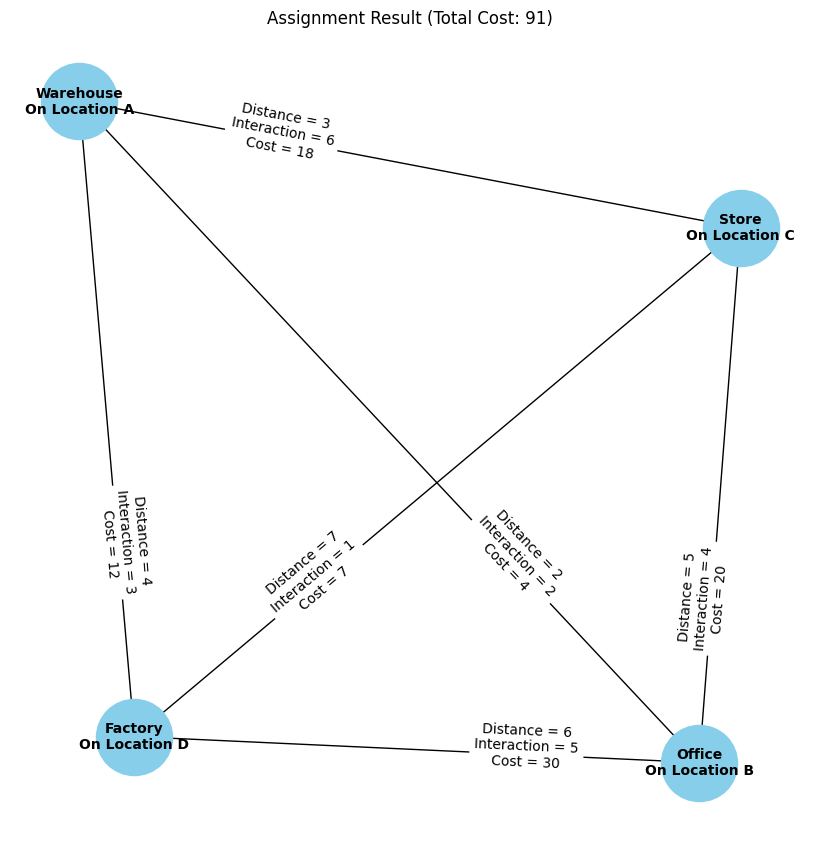

In [9]:
from QAP.model import solution_to_map

assign_facilities(solution_to_map(
    gurobi_result, model["q"], size=4),
    location_name, facility_name, distance_matrix, interaction_matrix)

## Quadratic Programming Complexity

Where $N$ = Number of Facilities = Number of Locations

- Variables = $N^2$ = $\mathcal{O}(N^2)$
- Objective Terms = $\frac{N^4 - 2N^3 + N^2}{2}$ = $\mathcal{O}(N^4)$
- Constraints = $2N$ = $\mathcal{O}(N)$

# Limitation of Solvers

## Constraint Weight

In previous example, I have set weight to $100$ because if left at default value (which is $1$), Fixstars and D-Wave will not be able to find the optimal solution.

In [11]:
default_weight_model = create_qap_qp_model(distance_matrix, interaction_matrix)

fs_result = solve(default_weight_model["model"], fixstar_client)

In [13]:
print(fs_result.client_result)

{"execution_time":{"annealing_time":942.620588,"queue_time":3832.3251299999997,"cpu_time":0.160374,"time_stamps":[31.079759]},"energies":[2.0],"spins":[[0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0]],"feasibilities":[false],"execution_parameters":{"num_gpus":1,"timeout":1000,"num_iterations":15,"penalty_calibration":true,"penalty_multipliers":[1.5361225995337007,1.2969566982968748,1.1790515439062499,1.2969566982968748,1.510218859402132,1.4089636317667515,1.2969566982968748,1.523724600176423],"version":"v0.8.8-H100 80GB HBM3"},"message":""}


From the following result, we can see that `energies` is equal to $2.0$ which is lower than the optimal solution.

Fixstars and D-Wave both use annealing technique to solve the problem, this technique require the problem to be encoded as QUBO (Quadratic Unconstrained Binary Optimization).

According to Fixstars Amplify's documentation https://amplify.fixstars.com/en/docs/amplify/v0/constraint.html:

> However, QUBO and Ising models, which you need to use for quantum annealing machines and Ising machines, cannot directly handle such constraints. One basic approach to deal with constraints is to prepare a penalty function $g$, which takes the minimum value if and only if the constraint is satisfied, and adds it to the original objective $f$ function with a weight $\lambda$.

> In other words, by finding the optimal solution of $f' = f + \lambda g$ $(\lambda \gt 0)$ instead of $f$, a solution will be obtained where the penalty function $g$ take the minimum value and therefore satisfies the constraint condition. In practice, since the output of the machine is not always a solution that satisfies the constraints, you must identify that the solution is feasible by checking if $g$ takes the minimum value at the solution.

For example, if our constraint is $q_0 + q_1 = 1$, $g$ will be $g = (q_0 + q_1 - 1)^2$.

As you can see, if the weight $\lambda$ is too low, the solver may give solution that does not satisfy the constraint.

## Problem Size

D-Wave Advantage is effected by the problem size as it has limited number of qubits.

## Solvers Limitation Test

In [1]:
from Utils.graph import create_qap_input
from Utils.solvers import GetGurobiClient, GetFixstarsClient, GetDWaveClient
from QAP.model import create_qap_qp_model
from amplify import solve

def solve_three_solvers(size: int, min: int, max: int, weight = 1_000_000):
    distance_matrix, interaction_matrix = create_qap_input(size, min, max, 1)
    model = create_qap_qp_model(distance_matrix, interaction_matrix, weight)

    gurobi_client = GetGurobiClient(timeout_sec=10)
    gurobi_error = None
    try:
        gurobi_result = solve(model["model"], gurobi_client)
    except Exception as e:
        gurobi_result = None
        gurobi_error = e

    fixstar_client = GetFixstarsClient(timeout=10000)
    fixstar_error = None
    try:
        fixstar_result = solve(model["model"], fixstar_client)
    except Exception as e:
        fixstar_result = None
        fixstar_error = e

    dwave_client = GetDWaveClient()
    dwave_error = None
    try:
        dwave_result = solve(model["model"], dwave_client)
    except Exception as e:
        dwave_result = None
        dwave_error = e

    try:
        if gurobi_result is not None:
            print(f"Gurobi Objective: {gurobi_result.best.objective}")
        else:
            print(f"Gurobi Error: {gurobi_error}")
    except:
        print(f"Gurobi Error: {gurobi_error}")
    
    try:
        if fixstar_result is not None:
            print(f"Fixstars Objective: {fixstar_result.best.objective}")
        else:
            print(f"Fixstars Error: {fixstar_error}")
    except:
        print(f"Fixstars Error: {fixstar_error}")
    
    try:
        if dwave_result is not None:
            print(f"D-Wave Objective: {dwave_result.best.objective}")
        else:
            print(f"D-Wave Error: {dwave_error}")
    except:
        print(f"D-Wave Error: {dwave_error}")

    return gurobi_result, fixstar_result, dwave_result, gurobi_error, fixstar_error, dwave_error

In [15]:
r6_w1 = solve_three_solvers(6, 1, 9, 1)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 314.0
Fixstars Error: None
D-Wave Error: None


In [16]:
r6_w1k = solve_three_solvers(6, 1, 9, 1_000)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 314.0
Fixstars Objective: 314.0
D-Wave Objective: 365.0


Setting Weight fixes infeasible problem with Fixstars and D-Wave

In [2]:
r6_w1m = solve_three_solvers(6, 1, 9, 1_000_000)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 187.0
Fixstars Objective: 187.0
D-Wave Objective: 196.0


In [7]:
for i in range(3):
    print(f"Execution Time = {r6_w1m[i].execution_time}")
    print(f"Solution Time = {r6_w1m[i].solutions[0].time}")

0:00:00.091022
0:00:00.083721
0:00:10.006070
0:00:00.058882
0:00:00.228921
0:00:00.228921


In [17]:
r6_w1t = solve_three_solvers(6, 1, 9, 1_000_000_000_000)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 314.0
Fixstars Objective: 344.0
D-Wave Objective: 342.0


In [22]:
r6_w1t_2 = solve_three_solvers(6, 1, 9, 1_000_000_000_000)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 314.0
Fixstars Objective: 354.0
D-Wave Objective: 348.0


Setting different weight effects solution

In [24]:
r7 = solve_three_solvers(7, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 435.0
Fixstars Objective: 435.0
D-Wave Error: None


In [25]:
r7[2].best.objective

RuntimeError: result has no feasible solution

In [26]:
r7_1b = solve_three_solvers(7, 1, 9, 1_000_000_000)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 435.0
Fixstars Objective: 435.0
D-Wave Error: None


Starting from $n = 7$, D-Wave can no longer find feasible solution

In [27]:
r8 = solve_three_solvers(8, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14


Gurobi Objective: 639.0
Fixstars Objective: 639.0
D-Wave Error: None


In [28]:
r8[2].best.objective

RuntimeError: result has no feasible solution

In [29]:
r10 = solve_three_solvers(10, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 793.0
Fixstars Objective: 793.0
D-Wave Error: None


In [30]:
r10[2].best.objective

RuntimeError: result has no feasible solution

In [31]:
# Gurobi Execution Time
r10[0].execution_time

datetime.timedelta(seconds=7, microseconds=524940)

In [35]:
r11 = solve_three_solvers(11, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 1079.0
Fixstars Objective: 1076.0
D-Wave Error: None


In [36]:
r11[0].execution_time

datetime.timedelta(seconds=10, microseconds=2028)

In [32]:
r12 = solve_three_solvers(12, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 1231.0
Fixstars Objective: 1190.0
D-Wave Error: None


In [34]:
# Gurobi Execution Time
r12[0].execution_time

datetime.timedelta(seconds=10, microseconds=15096)

At $n = 11$, Gurobi starts giving worse answer than Fixstars and noticeable at $n = 12$

This is due to Gurobi hitting 10 seconds time limit we have set.

In [37]:
r13 = solve_three_solvers(13, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 1501.0
Fixstars Objective: 1476.0
D-Wave Error: None


In [40]:
r14 = solve_three_solvers(14, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 1595.0
Fixstars Objective: 1540.0
D-Wave Error: both clique and minor embeddings failed: the problem size may be too large to embed in the target graph


At $n = 14$, problem size is now too big for D-Wave to embed problem to even attempt to solve.

In [12]:
r20 = solve_three_solvers(20, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 4556.0
Fixstars Objective: 4472.0
D-Wave Error: both clique and minor embeddings failed: the problem size may be too large to embed in the target graph


In [18]:
print(r20[1].execution_time)
print(r20[1].solutions[0].time)

0:00:09.968899
0:00:02.461229


### Finding Fixstars' Real Execution Time

When using `.execution_time`, the time is always equal to `timeout` set.

Using `.solutions[0].time` gives the real execution time.

In [ ]:
r69 = solve_three_solvers(69, 1, 9)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14
Gurobi Objective: 58194.0
Fixstars Objective: 53338.0
D-Wave Error: Failed during initialization.  This typically occurs when the source graph is unreasonably large or when the embedding problem is over-constrained (via max_fill, initial_chains, fixed_chains, and/or restrict_chains).


Note: Running problem at very big size takes a lot of time to encode problem and upload to solver.

## Limitation Test Summary

- Setting Weight fixes infeasible problem with Fixstars and D-Wave

- Setting different weight effects solution of Fixstars and D-Wave

- Starting from $n = 7$, D-Wave can no longer find feasible solution

- At $n = 11$, Gurobi starts giving worse answer than Fixstars and noticeable at $n = 12$. This is due to Gurobi hitting 10 seconds time limit we have set.

- At $n = 14$, problem size is now too big for D-Wave to embed problem to even attempt to solve.

- At $n = 69$, Gurobi and Fixstars can still solve the problem (obviously not optimal solution) but it take very long to encode and upload the problem.

# Benchmark

This benchmark will compare these solvers (and its variant):

- Brute Force (Time Limit set to 100 seconds)

- Gurobi (Time Limit set to 10 seconds)

- Gurobi (Time Limit set to 1000 seconds)

- Fixstars (Time Limit set to 10 seconds / Limit of Free Tier)

- D-Wave (Developer Plan)

The benchmark will runs on these test matrix:

- $n$ set to $4, 5, 6, 7, 8, 10, 12, 15, 20$ and $69$.

- Constraint Weight set to $1\,000, 1\,000\,000$ and $1\,000\,000\,000$

- Each test matrix will be run 3 times

- Total Test Run = $90$

Dataset:

- For same $n$, the same dataset (3 sets) will be used for all constraint weight.

Benchmark will compare the answer and time taken.

## Plotting Result

In [1]:
# Import Object from result.json
import json

with open('result_v3.json') as f:
    data = json.load(f)

print(data[:3])

[{'nodes': 4, 'max_edge_weight': 9, 'avg_edge_weight': 4.125, 'distance_matrix': [[0, 8, 8, 4], [8, 0, 8, 4], [8, 8, 0, 1], [4, 4, 1, 0]], 'interaction_matrix': [[0, 1, 6, 5], [1, 0, 4, 8], [6, 4, 0, 9], [5, 8, 9, 0]], 'qp_weight': 1000, 'time_model_formulation': 0.0005440711975097656, 'solvers_results': [{'name': 'Brute Force', 'objective': 149, 'execution_time': 2.09808349609375e-05}, {'name': 'Gurobi 10s', 'objective': 149.0, 'execution_time': 0.00545}, {'name': 'Gurobi 1000s', 'objective': 149.0, 'execution_time': 0.00614}, {'name': 'Fixstars', 'objective': 149.0, 'execution_time': 0.038017}, {'name': 'D-Wave', 'objective': 149.0, 'execution_time': 0.190523}]}, {'nodes': 4, 'max_edge_weight': 9, 'avg_edge_weight': 4.6875, 'distance_matrix': [[0, 9, 6, 7], [9, 0, 3, 7], [6, 3, 0, 7], [7, 7, 7, 0]], 'interaction_matrix': [[0, 4, 9, 7], [4, 0, 7, 5], [9, 7, 0, 4], [7, 5, 4, 0]], 'qp_weight': 1000, 'time_model_formulation': 0.00037932395935058594, 'solvers_results': [{'name': 'Brute Fo

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

### Success Count by Solver vs $n$

D-Wave starts to fail from $n = 7$, while Fixstars and Gurobi can still solve the problem.

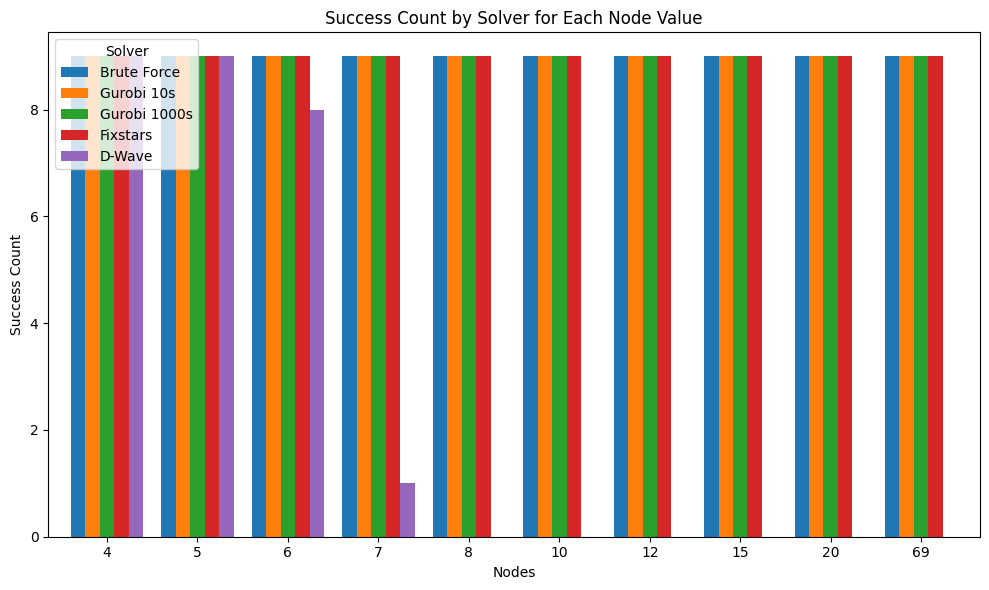

In [3]:
# Prepare data for plotting
records = []
for item in data:
    nodes = item["nodes"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"nodes": nodes, "solver": solver["name"], "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by nodes and solver to count successes
success_counts = df.groupby(["nodes", "solver"]).sum().reset_index()

# Pivot data for plotting
pivot_data = success_counts.pivot(index="nodes", columns="solver", values="success").fillna(0)

# Ensure legend order
solver_order = ["Brute Force", "Gurobi 10s", "Gurobi 1000s", "Fixstars", "D-Wave"]
pivot_data = pivot_data[solver_order]

# Plot multi-bar chart
pivot_data.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title("Success Count by Solver for Each Node Value")
plt.xlabel("Nodes")
plt.ylabel("Success Count")
plt.legend(title="Solver", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Success Count by Solver vs Constraint Weight

It seems to not effect Success Count significantly.

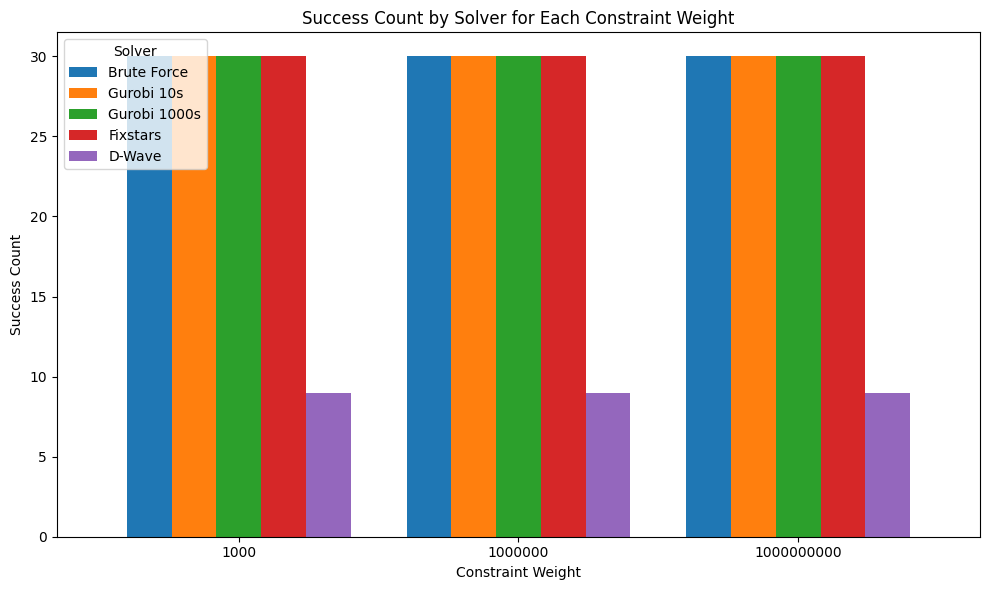

In [4]:
# Prepare data for plotting
records = []
for item in data:
    qp_weight = item["qp_weight"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"qp_weight": qp_weight, "solver": solver["name"], "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by qp_weight and solver to count successes
success_counts = df.groupby(["qp_weight", "solver"]).sum().reset_index()

# Pivot data for plotting
pivot_data = success_counts.pivot(index="qp_weight", columns="solver", values="success").fillna(0)

# Ensure legend order
solver_order = ["Brute Force", "Gurobi 10s", "Gurobi 1000s", "Fixstars", "D-Wave"]
pivot_data = pivot_data[solver_order]

# Plot multi-bar chart
pivot_data.plot(kind="bar", figsize=(10, 6), width=0.8)
plt.title("Success Count by Solver for Each Constraint Weight")
plt.xlabel("Constraint Weight")
plt.ylabel("Success Count")
plt.legend(title="Solver", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Success Count by Solver vs Nodes and Constraint Weight

Brute Force is omitted as it always success, Gurobi 10s is omitted because there is already Gurobi 1000s.

It seems to not effect Success Count significantly.

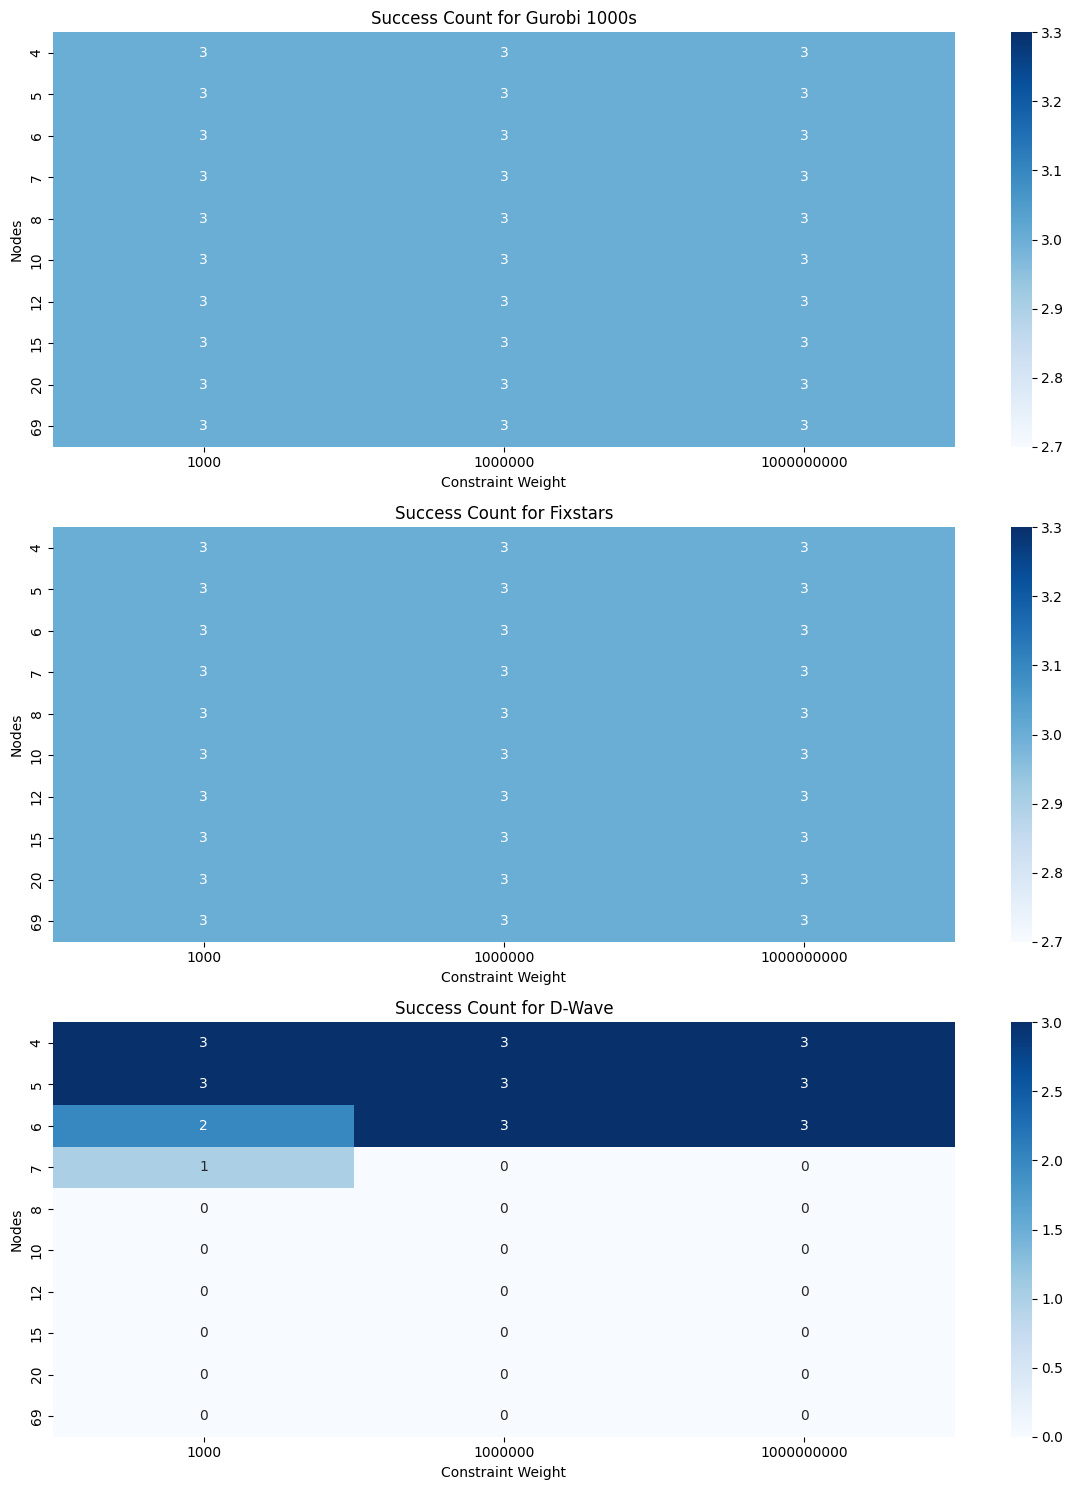

In [5]:
# Prepare data for plotting
records = []
for item in data:
    nodes = item["nodes"]
    qp_weight = item["qp_weight"]
    for solver in item["solvers_results"]:
        success = solver["objective"] is not None and solver["execution_time"] is not None
        records.append({"nodes": nodes, "qp_weight": qp_weight, "solver": solver["name"], "success": int(success)})

# Convert to DataFrame
df = pd.DataFrame(records)

# Group by nodes, qp_weight, and solver to count successes
success_counts = df.groupby(["nodes", "qp_weight", "solver"]).sum().reset_index()

# Filter solvers to include only Gurobi 1000s, Fixstars, and D-Wave
filtered_solvers = ["Gurobi 1000s", "Fixstars", "D-Wave"]
filtered_data = success_counts[success_counts["solver"].isin(filtered_solvers)]

# Plot multi heatmaps for each solver
fig, axes = plt.subplots(nrows=len(filtered_solvers), figsize=(12, 5 * len(filtered_solvers)))
if len(filtered_solvers) == 1:  # If there's only one solver, axes is not a list
    axes = [axes]

for ax, solver in zip(axes, filtered_solvers):
    solver_data = filtered_data[filtered_data["solver"] == solver]
    heatmap_data = solver_data.pivot(index="nodes", columns="qp_weight", values="success").fillna(0)
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Success Count for {solver}")
    ax.set_xlabel("Constraint Weight")
    ax.set_ylabel("Nodes")

plt.tight_layout()
plt.show()

### Box and Whisker Plot of Execution Time vs Nodes

Note: D-Wave (Last Column) is missing from $n = 8$ because there is no data.

- Brute Force increases linearly in log scale = exponentially until hitting the time limit of 100 ($10^2$) seconds
at $n = 12$ (Note: $n = 11$ is not tested).

- Gurobi also seems to increases exponentially until hitting the time limit of
10 ($10^1$) seconds at $n = 10$ and 1000 ($10^3$) seconds at $n = 15$.
(Note: $n = 9$ and $n = 13, 14$ is not tested) 

- Fixstars and D-Wave does not seem to increases exponentially (Note: x-axis is not linear as $n$ test is not linear).

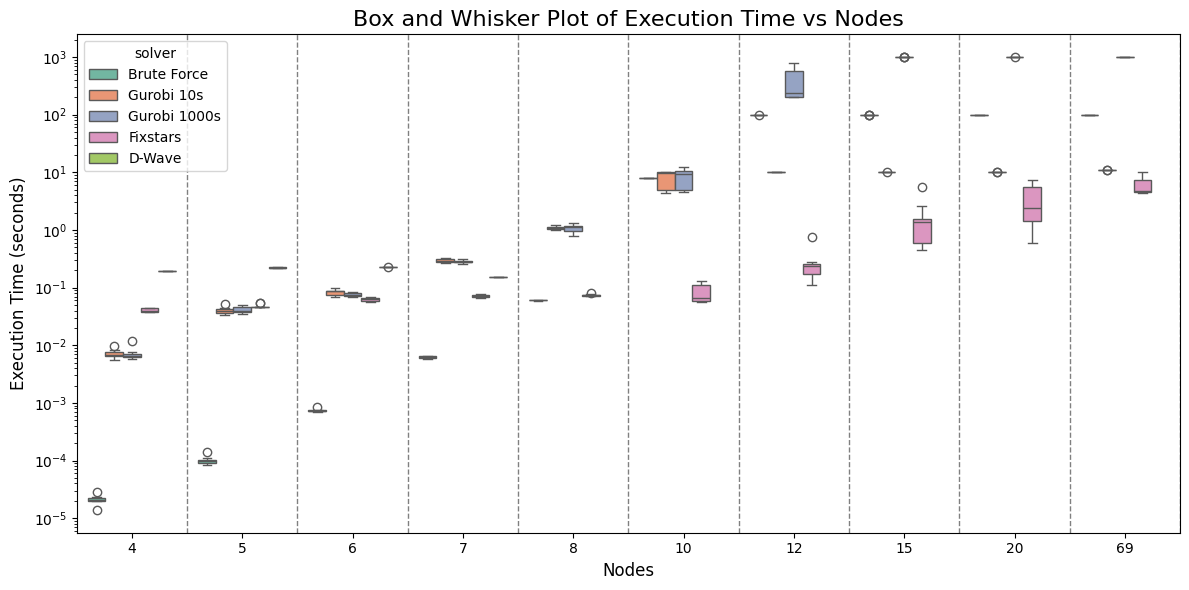

In [6]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": result["name"],
            "execution_time": result["execution_time"]
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for execution_time vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="execution_time", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Execution Time vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

plt.yscale("log")

# Show the plot
plt.tight_layout()
plt.show()

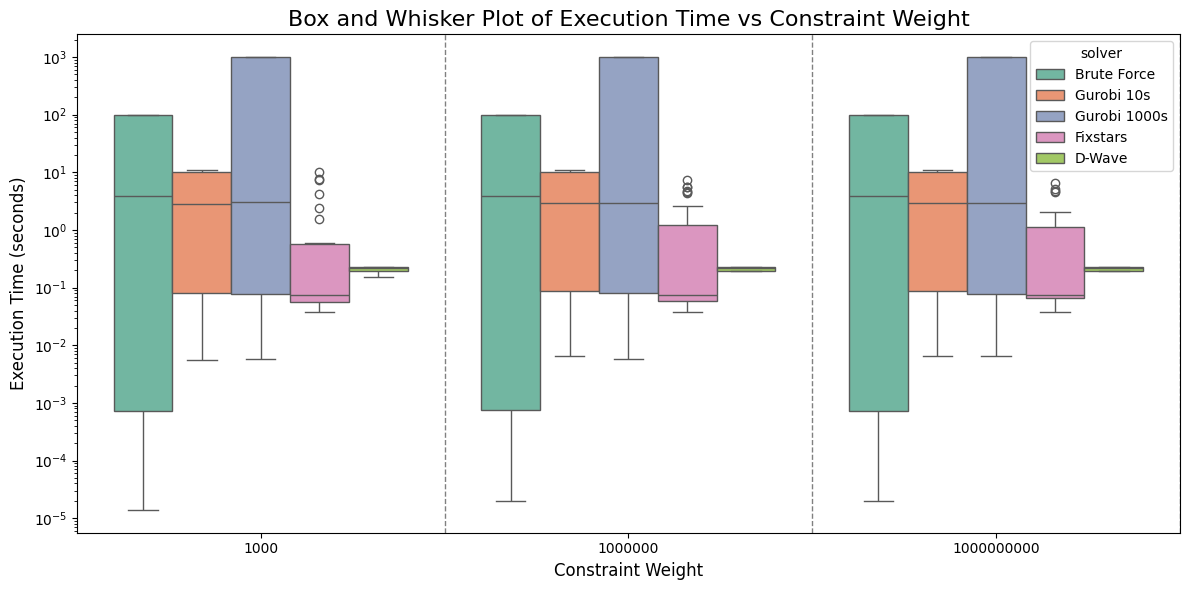

In [19]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    for result in dataset["solvers_results"]:
        plot_data.append({
            "qp_weight": dataset["qp_weight"],
            "solver": result["name"],
            "execution_time": result["execution_time"]
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for execution_time vs qp_weight
plt.figure(figsize=(12, 6))
sns.boxplot(x="qp_weight", y="execution_time", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Execution Time vs Constraint Weight', fontsize=16)
plt.xlabel('Constraint Weight', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)

# Add vertical lines as guidelines to separate each "qp_weight" group
qp_weight = df_plot['qp_weight'].unique()
for node in qp_weight:
    plt.axvline(x=list(qp_weight).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

plt.yscale("log")

# Show the plot
plt.tight_layout()
plt.show()

### Linear Plot of Execution Time for Fixstars and D-Wave

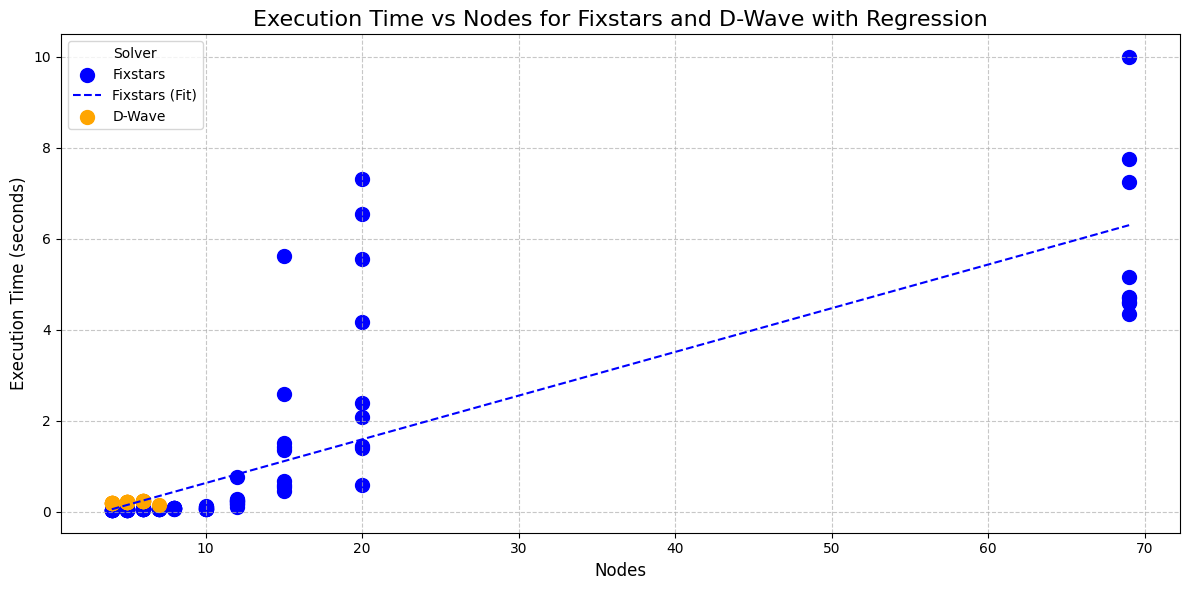

In [11]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    nodes = dataset["nodes"]
    for result in dataset["solvers_results"]:
        if result["execution_time"] is not None:  # Include only valid execution times
            plot_data.append({
                "nodes": nodes,
                "solver": result["name"],
                "execution_time": result["execution_time"]
            })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Filter data for Fixstars and D-Wave
fixstars_data = df_plot[df_plot["solver"] == "Fixstars"]
dwave_data = df_plot[df_plot["solver"] == "D-Wave"]

# Function to perform linear regression and get line points
def add_regression_line(x, y, ax, label, color):
    # Reshape data for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y)
    
    # Predict y values for regression line
    x_line = np.linspace(min(x), max(x), 100)
    y_line = model.predict(x_line.reshape(-1, 1))
    
    # Plot the regression line
    ax.plot(x_line, y_line, label=f"{label} (Fit)", color=color, linestyle='--')

# Create scatter plot with regression lines
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot scatter for Fixstars
plt.scatter(fixstars_data["nodes"], fixstars_data["execution_time"], label="Fixstars", color="blue", s=100)
add_regression_line(fixstars_data["nodes"], fixstars_data["execution_time"], ax, "Fixstars", "blue")

# Plot scatter for D-Wave
plt.scatter(dwave_data["nodes"], dwave_data["execution_time"], label="D-Wave", color="orange", s=100)
# add_regression_line(dwave_data["nodes"], dwave_data["execution_time"], ax, "D-Wave", "orange")

# Add labels, legend, and title
plt.title("Execution Time vs Nodes for Fixstars and D-Wave with Regression", fontsize=16)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Execution Time (seconds)", fontsize=12)
plt.legend(title="Solver", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Objective vs Nodes

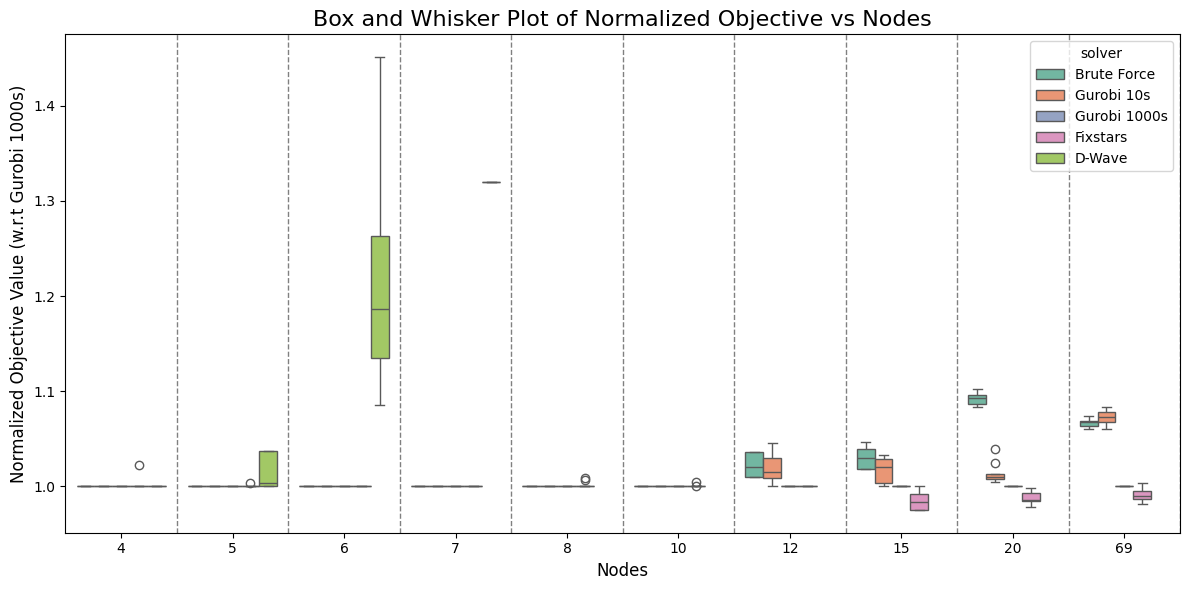

In [8]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    # Extract objective value of Gurobi 1000s to normalize others
    gurobi_1000s_objective = next(
        result["objective"] for result in dataset["solvers_results"] if result["name"] == "Gurobi 1000s"
    )
    
    for result in dataset["solvers_results"]:
        # Skip failed solvers where objective is None
        if result["objective"] is None:
            continue
        
        # Normalize the objective value
        normalized_objective = result["objective"] / gurobi_1000s_objective if gurobi_1000s_objective != 0 else 0
        plot_data.append({
            "nodes": dataset["nodes"],
            "solver": result["name"],
            "normalized_objective": normalized_objective
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for normalized objective vs nodes
plt.figure(figsize=(12, 6))
sns.boxplot(x="nodes", y="normalized_objective", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Normalized Objective vs Nodes', fontsize=16)
plt.xlabel('Nodes', fontsize=12)
plt.ylabel('Normalized Objective Value (w.r.t Gurobi 1000s)', fontsize=12)

# Add vertical lines as guidelines to separate each "nodes" group
nodes = df_plot['nodes'].unique()
for node in nodes:
    plt.axvline(x=list(nodes).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()

### Box and Whisker Plot of Objective vs Constraint Weight

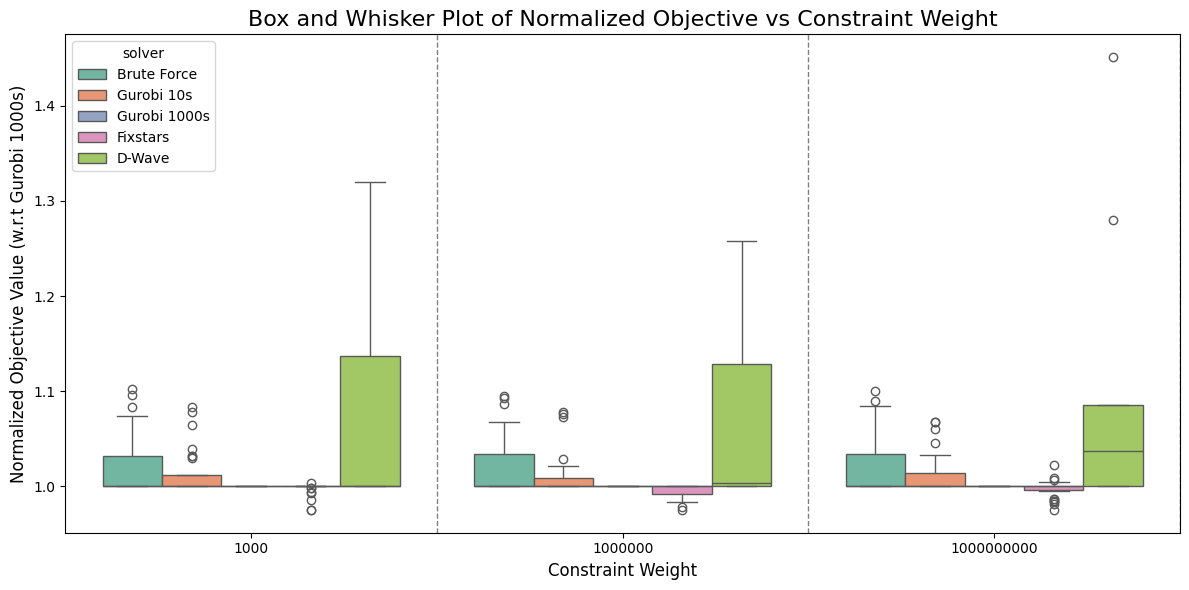

In [5]:
# Prepare data for plotting
plot_data = []
for dataset in data:
    # Extract objective value of Gurobi 1000s to normalize others
    gurobi_1000s_objective = next(
        result["objective"] for result in dataset["solvers_results"] if result["name"] == "Gurobi 1000s"
    )
    
    for result in dataset["solvers_results"]:
        # Skip failed solvers where objective is None
        if result["objective"] is None:
            continue
        
        # Normalize the objective value
        normalized_objective = result["objective"] / gurobi_1000s_objective if gurobi_1000s_objective != 0 else 0
        plot_data.append({
            "qp_weight": dataset["qp_weight"],
            "solver": result["name"],
            "normalized_objective": normalized_objective
        })

# Convert to DataFrame
df_plot = pd.DataFrame(plot_data)

# Box and Whisker Plot for normalized objective vs qp_weight
plt.figure(figsize=(12, 6))
sns.boxplot(x="qp_weight", y="normalized_objective", hue="solver", data=df_plot, palette="Set2")

# Add title and labels
plt.title('Box and Whisker Plot of Normalized Objective vs Constraint Weight', fontsize=16)
plt.xlabel('Constraint Weight', fontsize=12)
plt.ylabel('Normalized Objective Value (w.r.t Gurobi 1000s)', fontsize=12)

# Add vertical lines as guidelines to separate each "qp_weight" group
qp_weight = df_plot['qp_weight'].unique()
for node in qp_weight:
    plt.axvline(x=list(qp_weight).index(node) + 0.5, color='gray', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()

# Summary

- Fixstars gives the best solution with fastest runtime.

- For small problem $n \leq 8$, Gurobi is better because it runs locally, because of that it is also faster as it does not need to upload the problem and wait for queue.

- D-Wave is not good for dense matrix. Therefore, it can only solve small QAP problem.